In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.185872  0.143386  0.615301  0.378939 -1.375968 -0.011214 -0.055960   
  1   0.249934 -0.609847  0.039844 -0.618497 -0.914752 -0.325126 -0.634179   
  2  -0.109348 -0.507836  0.944427 -0.609895 -0.351889 -0.006364  0.223270   
  3   0.698134 -0.213106  0.634071 -0.403735  0.062114 -0.608983 -0.319813   
  4  -0.202454 -0.684654  1.403728 -0.447867 -0.574945  0.081449  0.392864   
  5  -0.811659  0.019946 -0.666339  0.257026  0.090137  0.493534 -0.231494   
  6   1.448926  0.551030 -0.092724 -0.136308 -1.063230 -0.495924 -0.157202   
  7   0.073929 -0.594927 -0.864646 -1.227485 -1.101518 -0.743266 -0.432512   
  8  -0.054007  0.252742 -0.047587 -0.832988 -1.337621  0.424265  0.246029   
  9   1.054908 -0.085715  0.753869 -0.462998  0.167255  0.030220 -0.465931   
  10 -0.501146 -0.610380  0.119569  0.003738 -1.107739 -0.055320 -0.079328   
  11  0.182253 -0.976388  0.248072 -0.337688 -0.943044 -0.322706 -0.606789   
  12  0.211740  0.812988  0.498236  0.215452 -0.255623 -1.512703 -0.479737   
  13  0.573736  0.056247 -0.047657  0.480504 -0.490546 -0.011120 -0.375293   
  14  0.127331  0.189505  0.267941 -0.912805 -1.750327 -0.609671 -0.629760   
  15 -0.334187  0.293028  0.450150 -0.438254 -1.427444 -0.914523 -0.623561   
  16 -0.251462 -0.115191 -0.500223 -0.510902 -0.547152 -0.580953  0.218154   
  17  0.628151  0.464321  0.663866  0.243175 -0.420989 -0.390862 -0.538405   
  18  0.210646  0.833821  0.704946  0.031015 -0.620930 -0.783799 -0.101741   
  19 -0.047232 -0.232302 -0.266663  0.522766 -1.394674 -0.794619  0.130500   
  20  0.655955  0.574915  0.107341 -0.629357 -0.948169 -0.589424  0.118011   
  21  0.161023  0.928620 -0.249137 -0.141163 -0.784992 -0.384495  0.040689   
  22 -0.269762  0.103697  0.075010 -0.280387 -0.572499 -0.392610  0.755872   
  23  0.194728  0.157473  0.561627 -0.233348 -1.541182 -1.006242 -0.387014   
  24 -0.024060  0.757056  0.898409 -0.146115 -0.458237 -0.080970  0.213620   
1 0  -0.002755 -1.004760 -0.996752 -0.373074 -0.100145 -0.467407 -0.449214   
  1  -0.036870  0.653478 -0.126041 -0.016171  0.405382 -0.364918  0.879734   
  2   0.963215  0.694840 -0.341805 -0.209523  0.409161  0.269171  1.071559   
  3   0.403758 -0.171864 -0.762580  0.066664 -0.535434 -0.523911  1.264820   
  4   0.216618 -0.153952  0.365725 -0.735454  1.039915  0.029395  1.349748   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.364891  0.081247  0.786919  ... -0.582248 -0.352964 -0.077809   
  1  -0.449669 -0.398020  0.644032  ...  0.569410  0.359245  1.074786   
  2   0.296629 -0.860220 -1.302610  ...  0.248205  0.611779 -0.304859   
  3   0.168766  0.640670  0.252280  ... -0.479996  0.365091  0.729901   
  4   0.209893  0.325570  0.851872  ... -0.584585  0.190726 -0.717172   
  5  -0.206240  0.910335 -0.309495  ... -1.708947 -0.550153 -0.741593   
  6  -0.301525  0.016374  0.329764  ...  0.186342  0.392515  0.524983   
  7   0.326250  0.058114  0.015168  ... -0.262896  0.769836 -0.121108   
  8  -0.491809 -0.585923  0.383365  ... -0.226112 -0.598791 -0.386857   
  9  -0.204048 -0.428663 -0.306971  ...  0.374391 -0.047719  0.247911   
  10  0.087578  0.177961 -0.092864  ... -1.336908 -0.696294 -0.300922   
  11 -0.334287  0.138794  0.035675  ...  0.216371  0.064235 -0.380606   
  12 -0.952195 -0.427430  0.979564  ...  0.425997  0.448797  0.337307   
  13 -0.302371 -0.961746  0.686459  ...  0.556414 -0.679268 -0.023709   
  14  0.375615  0.196236 -0.265808  ...  0.466078 -0.551382 -0.602733   
  15  0.008154  0.305897  0.425986  ... -0.028084  0.529140  0.401324   
  16  0.670590  0.005414 -0.360943  ...  0.651633  0.986200  0.178032   
  17 -0.020146  0.492713  0.305262  ...  0.279584 -0.488413 -0.040569   
  18 -0.935354 -0.724136 -0.009775  ...  0.192456 -0.552297 -0.309859   
  19 -0.494168 -0.037879 -0.088952  ... -0.644409 -0.421907  0.708448   
  20  0.058658  0.418810 -0.033765  ...  0.470206  0.079037 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|   2.5 %    97.5 %
D  1.002031  0.041394  24.207102  1.872808e-129  0.9209  1.083162


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



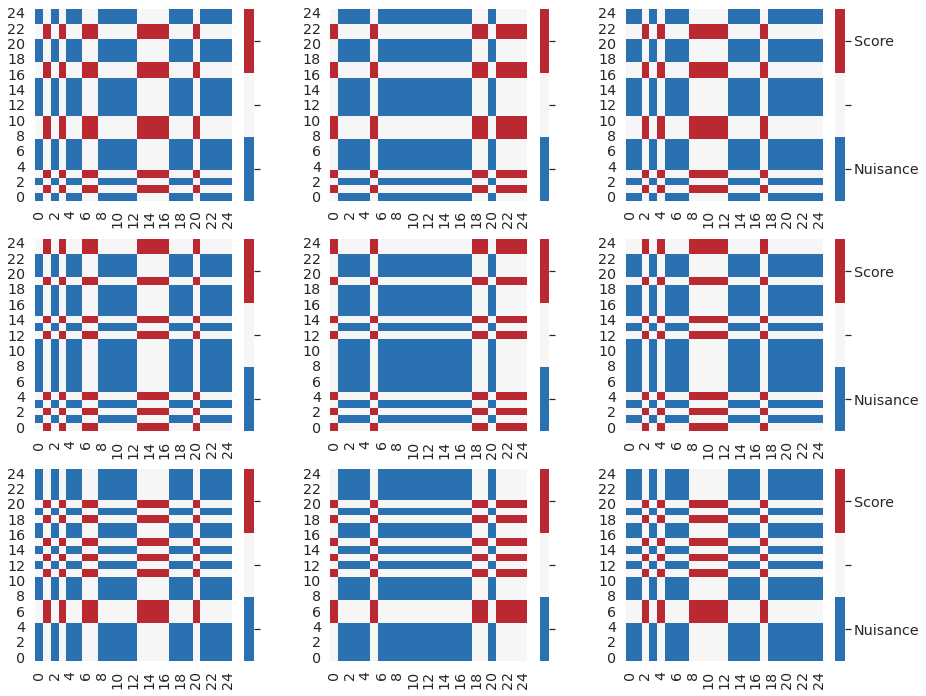

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



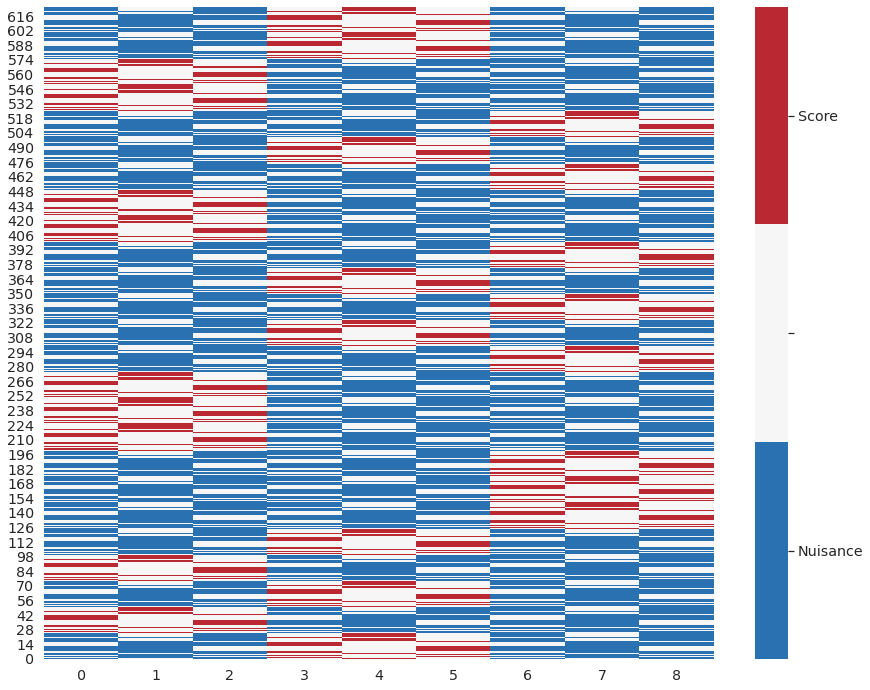

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])